# Prediction demonstrator

This notebook illustrates the main tools of the prediction pipeline based on an example.

There are four steps to the pipeline:
1. Data loading and preprocessing
2. Data visualization
3. Prediction
5. Prediction visualization

## Prerequisites 

### BASH commands

Create a python virtual environment with 
```
python3 -m venv .venv
```
and activate it using 
```
source .venv/bin/activate
```

Import the necessary libraries with 
```
pip install -r requirements.txt
```

Import the goodforest library with 
```
pip install .
```

Select the `.venv` kernel for the jupyter notebook (you might need to refresh it)

### Importing the packages

In [10]:
import torch
import rasterio
from torchsummary import summary
from goodforest_lib.models.RSPR_UNetPlusPlus.model_no_normalization import RSPRUNetPlusPlus
from goodforest_lib.models.RSPR_UNetPlusPlus.predict import Predict
from goodforest_lib.models.RSPR_UNetPlusPlus.prediction_viz import visualize_prediction, visualize_best_prob_heatmap, visualize_nb_pred_heatmap
from rasterio.features import rasterize
import os
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx

## 1. Data loading

The module `load_data` in the `goodforest_lib` library contains the functions for data loading.

### 1.1. Visualize the area of interest

To open the shapefile and display the area of interest:

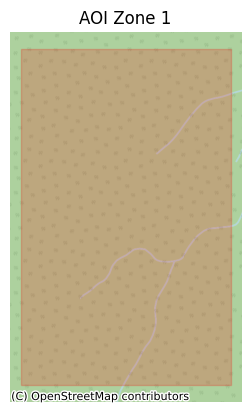

In [11]:
# Open the shapefile
shapefile_path = "aois_zones_small/aoi_zone_1-small.shp"

shapefile = gpd.read_file(shapefile_path)

shapefile = shapefile.to_crs(epsg=3857)

# Plot the shapefile
ax = shapefile.plot(alpha=0.2, edgecolor='red', facecolor='r')
plt.title('AOI Zone 1')

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

plt.axis('off')
plt.show()

### 1.2. Data loading and preprocessing

The data is loaded from Sentinel-2 images and 13 vegetation indices (listed in the `config.vegetation_indices` module of the `goodforest_lib` library) are computed.

In [12]:
from goodforest_lib.load_data.load_S2_for_prediction import main as load_data_for_prediction

# Load the data
load_data_for_prediction(
    source_folder='aois_zones_small',
    before_date='2022-07-10',
    buffer=300)

ℹ️ Authenticating Earth Engine...
✅ Successfully authenticated Earth Engine!
✅ Shapefile loaded successfully.


Formatting geometry: 1it [00:00, 1618.17it/s]

✅ Formatted geometry for area of interest sucessfully


Total pixels: 2591
Not black pixels: 2361
Ratio: 0.09%
Processing image 2022-07-07 for tile 10UDF.


2022-07-07.tif: |          | 0.00/1.01M (raw) [  0.0%] in 00:00 (eta:     ?)

2022-07-07_cloud-mask.tif: |          | 0.00/41.9k (raw) [  0.0%] in 00:00 (eta:     ?)

### 1.3. Display the data

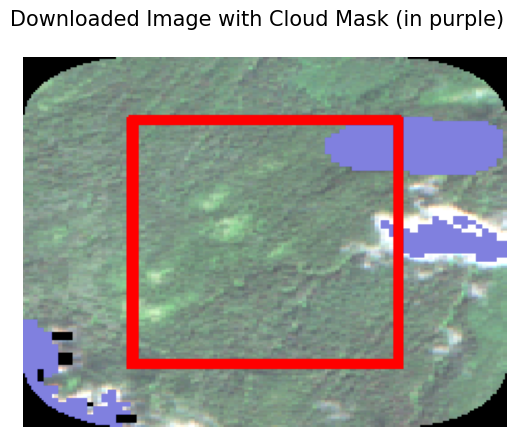

In [13]:
tif_path = os.path.join("aois_zones_small/aoi_0/10UDF/2022-07-07.tif")
cloud_mask_path = os.path.join("aois_zones_small/aoi_0/10UDF/2022-07-07_cloud-mask.npy")
shapefile = gpd.read_file(shapefile_path)

with rasterio.open(tif_path ,'r') as tif_image:
    clouds_mask = np.load(cloud_mask_path)

    profile = tif_image.profile
    rgb_image = tif_image.read([4, 3, 2])

    rgb_image = rgb_image.transpose(1, 2, 0) 
    rgb_percentile = np.percentile(rgb_image, [1, 99], axis=(0, 1)) 
    rgb_image = (rgb_image - rgb_percentile[0]) / (rgb_percentile[1] - rgb_percentile[0])
    rgb_image = np.clip(rgb_image, 0, 1)

    shapefile = gpd.read_file(shapefile_path)
    shapefile = shapefile.to_crs(profile['crs'])

    plt.suptitle('Downloaded Image with Cloud Mask (in purple)', fontsize=15)

    polygon_rasterized = rasterize(
        [(shapefile.geometry[0].boundary.buffer(2e-4), 1)],
        out_shape=(profile['height'], profile['width']),
        fill=0,    
        all_touched=True,
        dtype='uint8',
        transform=profile['transform'])

    tif_image_with_clouds = rgb_image.copy()

    tif_image_with_clouds = np.concatenate([tif_image_with_clouds, 0.7*np.ones((profile['height'], profile['width'], 1))], axis=2)
    
    black_mask = np.sum(tif_image_with_clouds[:, :, :3], axis=2) == 0
    tif_image_with_clouds[black_mask] = [0, 0, 0, 1]
    tif_image_with_clouds[clouds_mask == 1] = [0, 0, 0.75, 0.5]
    
    tif_image_with_clouds_polygon = tif_image_with_clouds.copy()
    tif_image_with_clouds_polygon[polygon_rasterized == 1] = [1, 0, 0, 1]

    plt.imshow(tif_image_with_clouds_polygon)
    plt.axis('off')
    plt.show()

## 2. Prediction

The prediction is ran using the `predict` module of `goodforest_lib` on all the images of the dataset.

### 2.1. Initialize the model

In [14]:
num_classes = 5 #Change this to the number of classes in your dataset
model = RSPRUNetPlusPlus(num_classes=num_classes, input_channels=24)

Downloading: "https://github.com/zhanghang1989/ResNeSt/zipball/master" to /home/tmazuir/.cache/torch/hub/master.zip
Using cache found in /home/tmazuir/.cache/torch/hub/zhanghang1989_ResNeSt_master


resnest101


### 2.2. Import the trained model

Add the weights you want to use for the prediction in the folder `models`.
The weights for the best trained model can be found on the Google Drive.

In [15]:
checkpoint = False # Change this to False if you don't have a checkpoint but a model state dictionary
if checkpoint:
    checkpoint_path = os.path.join("models", "checkpoint_epoch_101.pth") # Change this to the path of your checkpoint
    model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device("cpu"), weights_only=True)['model_state_dict'])
else:
    state_dict_path = os.path.join("models", 'best_model.pth') # Change this to the path of your model state dictionary
    model.load_state_dict(torch.load(state_dict_path, map_location=torch.device('cpu'),weights_only=True))



### 2.3 Predict on the dowloaded .tif file

Predicting on the image associated to `image_path`:

In [16]:
image_path = "aois_zones_small/aoi_0/10UDF/2022-07-07.tif"

predictor = Predict(model, num_classes)
pred_array, best_prob_array, nb_pred_array, profile = predictor.predict_image_file(image_path)

image shape:  torch.Size([1, 24, 179, 234])


### 2.4. Visualize the prediction

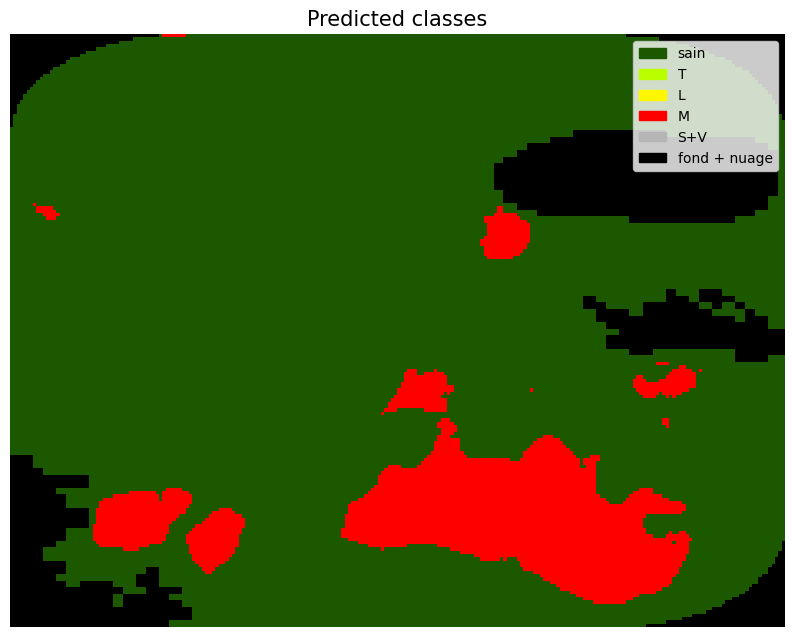

In [18]:
output_path_prediction = 'heatmaps/prediction_heatmap.png' # Change this to the path where you want to save the predictions heatmap
visualize_prediction(image_path, pred_array, output_path_prediction) # Change the output path to where you want to save the visualization

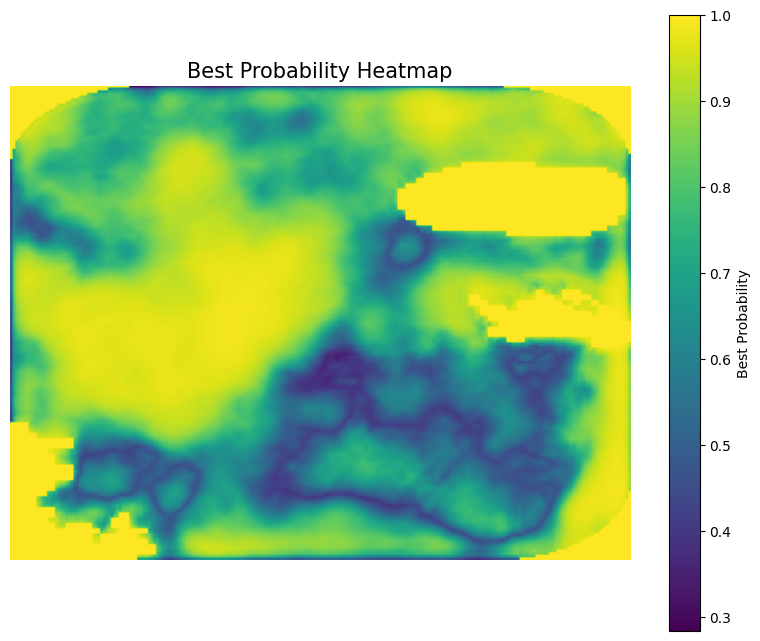

In [19]:
output_path_best_prop = os.path.join('heatmaps/best_prop_heatmap.png')
visualize_best_prob_heatmap(image_path, best_prob_array, output_path_best_prop)